In [1]:
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#pd.options.display.max_rows = 999
#pd.get_option("display.max_rows")

In [3]:
# Control whether to import the original data. 
import_original_data = True
write_excel = True

Mila:

OK only four files needed to be corrected. I put them in your Meta4 folder under the name Elviz_Corrected

The remaining four files indeed contained fewer contigs.

Thanks!


In [4]:
import sys
print sys.executable 
print (sys.version)

/usr/bin/python
2.7.5 (default, Mar  9 2014, 22:15:05) 
[GCC 4.2.1 Compatible Apple LLVM 5.0 (clang-500.0.68)]


In [5]:
print os.getcwd()

/Users/janet/elvizAnalysis


In [6]:
sns.set(style="whitegrid")

In [7]:
# Import the csv that translates the 127_HOW14 type labels to weeks and replicates.

from elviz_utils import IMPORT_METAINFO_TYPES, read_sample_info

In [8]:
sample_info = read_sample_info()

sample_info.head()

,ID,oxy,rep,week,project
0,1_LOW4,Low,1,4,1056013
1,13_LOW5,Low,1,5,1056037
2,25_LOW6,Low,1,6,1056061
3,37_LOW7,Low,1,7,1056085
4,49_LOW8,Low,1,8,1056109


In [9]:
# loop over each file, collapse rows that share phylogeny data to the genus label,
# save new .csv files, then append them all together in a separate step. 
#filepath = '/Volumes/Shares/Users/Janet/meta4/160121_elviz_files_updated/'
filepath = './data'
elviz_files = [f for f in os.listdir(filepath) if ".csv" in f]
print len(elviz_files)
!ls ./data/*.csv | wc -l

88
      88


In [10]:
from abundance_utils import read_and_reduce_elviz_csv

In [11]:
# import the raw or raw-ish data. 
if import_original_data:
    filepath = './raw_data'
    elviz_files = [f for f in os.listdir(filepath) if ".csv" in f]
    print elviz_files[1:4]

['elviz-contigs-1056016.csv', 'elviz-contigs-1056019.csv', 'elviz-contigs-1056022.csv']


In [12]:
#if not os.path.exists('./results'):
#    os.makedirs('./results/')
#if not os.path.exists('./plots'):
#    os.makedirs('./plots/')

from abundance_utils import make_directory

make_directory(dirpath="./plots")
make_directory(dirpath='results')

In [13]:
from abundance_utils import read_and_reduce_all

In [14]:
from abundance_utils import project_number_from_filename

In [15]:
project_number_from_filename(elviz_files[0])

elviz-contigs-1056013.csv


1056013

In [16]:
if import_original_data:
    data_reduced = read_and_reduce_all(filename_list=elviz_files,
                                       filepath=filepath,
                                       sample_info = sample_info)
    print data_reduced.size  
else: 
    data_reduced = pd.read_csv("./results/reduced_data--all_phylogeny_remains.csv")

data_reduced.head()

elviz-contigs-1056013.csv
elviz-contigs-1056016.csv
elviz-contigs-1056016.csv
elviz-contigs-1056019.csv
elviz-contigs-1056019.csv
elviz-contigs-1056022.csv
elviz-contigs-1056022.csv
elviz-contigs-1056025.csv
elviz-contigs-1056025.csv
elviz-contigs-1056028.csv
elviz-contigs-1056028.csv
elviz-contigs-1056031.csv
elviz-contigs-1056031.csv
elviz-contigs-1056034.csv
elviz-contigs-1056034.csv
elviz-contigs-1056037.csv
elviz-contigs-1056037.csv
elviz-contigs-1056040.csv
elviz-contigs-1056040.csv
elviz-contigs-1056043.csv
elviz-contigs-1056043.csv
elviz-contigs-1056046.csv
elviz-contigs-1056046.csv
elviz-contigs-1056049.csv
elviz-contigs-1056049.csv
elviz-contigs-1056052.csv
elviz-contigs-1056052.csv
elviz-contigs-1056055.csv
elviz-contigs-1056055.csv
elviz-contigs-1056058.csv
elviz-contigs-1056058.csv
elviz-contigs-1056061.csv
elviz-contigs-1056061.csv
elviz-contigs-1056064.csv
elviz-contigs-1056064.csv
elviz-contigs-1056067.csv
elviz-contigs-1056067.csv
elviz-contigs-1056070.csv
elviz-contig

,Kingdom,Phylum,Class,Order,Family,Genus,abundance,project,ID,oxy,rep,week
642,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,Methylobacter,0.275821,1056013,1_LOW4,Low,1,4
494,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylotenera,0.266561,1056013,1_LOW4,Low,1,4
198,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.066042,1056013,1_LOW4,Low,1,4
650,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,other,0.057880,1056013,1_LOW4,Low,1,4
478,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,other,0.036588,1056013,1_LOW4,Low,1,4


In [17]:
data_reduced['project'].unique()

array([1056013, 1056016, 1056019, 1056022, 1056025, 1056028, 1056031,
       1056034, 1056037, 1056040, 1056043, 1056046, 1056049, 1056052,
       1056055, 1056058, 1056061, 1056064, 1056067, 1056070, 1056073,
       1056076, 1056079, 1056082, 1056085, 1056088, 1056091, 1056094,
       1056097, 1056100, 1056103, 1056106, 1056109, 1056112, 1056115,
       1056118, 1056121, 1056124, 1056127, 1056130, 1056133, 1056136,
       1056139, 1056142, 1056145, 1056148, 1056151, 1056154, 1056157,
       1056160, 1056163, 1056166, 1056169, 1056172, 1056175, 1056178,
       1056181, 1056184, 1056187, 1056190, 1056193, 1056196, 1056199,
       1056202, 1056205, 1056208, 1056211, 1056214, 1056217, 1056220,
       1056223, 1056226, 1056229, 1056232, 1056235, 1056238, 1056241,
       1056244, 1056247, 1056250, 1056253, 1056256, 1056259, 1056262,
       1056265, 1056268, 1056271, 1056274])

In [18]:
if import_original_data:
    data_reduced.to_csv("./results/reduced_data--all_phylogeny_remains.csv", index=False)

In [19]:
# Should have only 1 row per Id now. 
data_reduced[data_reduced['Genus']=='Methylophilus'].head()

,Kingdom,Phylum,Class,Order,Family,Genus,abundance,project,ID,oxy,rep,week
493,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001669,1056013,1_LOW4,Low,1,4
515,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001356,1056016,2_LOW4,Low,2,4
499,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001524,1056019,3_LOW4,Low,3,4
468,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.000997,1056022,4_LOW4,Low,4,4
577,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001864,1056025,7_HOW4,High,1,4


In [20]:
from abundance_utils import prepare_excel_dictionary
  
prepare_excel_dictionary(dataframe = data_reduced)

{('High', 1): 'elviz_binned--HighO2_rep1.xlsx',
 ('High', 2): 'elviz_binned--HighO2_rep2.xlsx',
 ('High', 3): 'elviz_binned--HighO2_rep3.xlsx',
 ('High', 4): 'elviz_binned--HighO2_rep4.xlsx',
 ('Low', 1): 'elviz_binned--LowO2_rep1.xlsx',
 ('Low', 2): 'elviz_binned--LowO2_rep2.xlsx',
 ('Low', 3): 'elviz_binned--LowO2_rep3.xlsx',
 ('Low', 4): 'elviz_binned--LowO2_rep4.xlsx'}

In [21]:
#from abundance_utils import prepare_excel_writer_dict 
#prepare_excel_writer_dict(dataframe = data_reduced)

#from abundance_utils import write_excel
  
#write_excel(dataframe = data_reduced)

In [22]:
if write_excel:
    from abundance_utils import write_excel_files
    write_excel_files(dataframe = data_reduced, filepath = './results')

In [23]:
data_reduced.head()

,Kingdom,Phylum,Class,Order,Family,Genus,abundance,project,ID,oxy,rep,week
642,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,Methylobacter,0.275821,1056013,1_LOW4,Low,1,4
494,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylotenera,0.266561,1056013,1_LOW4,Low,1,4
198,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.066042,1056013,1_LOW4,Low,1,4
650,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,other,0.057880,1056013,1_LOW4,Low,1,4
478,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,other,0.036588,1056013,1_LOW4,Low,1,4


In [24]:
from abundance_utils import reduce_to_genus_only
data_reduced_genus = reduce_to_genus_only(data_reduced)
data_reduced_genus.head()

      Kingdom          Phylum                Class             Order  \
642  Bacteria  Proteobacteria  Gammaproteobacteria   Methylococcales   
494  Bacteria  Proteobacteria   Betaproteobacteria   Methylophilales   
198  Bacteria   Bacteroidetes       Flavobacteriia  Flavobacteriales   
650  Bacteria  Proteobacteria  Gammaproteobacteria   Methylococcales   
478  Bacteria  Proteobacteria   Betaproteobacteria   Burkholderiales   

                Family           Genus  abundance  project      ID  oxy  rep  \
642   Methylococcaceae   Methylobacter   0.275821  1056013  1_LOW4  Low    1   
494   Methylophilaceae   Methylotenera   0.266561  1056013  1_LOW4  Low    1   
198  Flavobacteriaceae  Flavobacterium   0.066042  1056013  1_LOW4  Low    1   
650   Methylococcaceae           other   0.057880  1056013  1_LOW4  Low    1   
478     Comamonadaceae           other   0.036588  1056013  1_LOW4  Low    1   

     week  
642     4  
494     4  
198     4  
650     4  
478     4  
Index([u'Kingd

,ID,rep,week,oxy,Genus,abundance,project
42797,76_LOW10,4,10,Low,Methylobacter,0.774854,1056166
45856,82_HOW10,4,10,High,Methylobacter,0.770596,1056178
2432,106_HOW12,4,12,High,Methylobacter,0.759018,1056226
26673,40_LOW7,4,7,Low,Methylobacter,0.757622,1056094
50891,94_HOW11,4,11,High,Methylobacter,0.745955,1056202


In [25]:
# Write a copy to csv
if import_original_data:
    data_reduced_genus.to_csv(
        "./results/reduced_data--genus_only.csv", index=False)

In [26]:
# print data_reduced_genus[['rep','week', 'ID']].drop_duplicates()

In [27]:
data_reduced_genus.head(3)

,ID,rep,week,oxy,Genus,abundance,project
42797,76_LOW10,4,10,Low,Methylobacter,0.774854,1056166
45856,82_HOW10,4,10,High,Methylobacter,0.770596,1056178
2432,106_HOW12,4,12,High,Methylobacter,0.759018,1056226


In [28]:
by_repl_and_week_Genus = data_reduced_genus.groupby(['rep','week','oxy'])#.to_excel(writer,sheet_name='Sheet1')
# check that replicates and week are in the right order: 
#for tup, d in by_repl_and_week_Genus:
#    print tup

In [29]:
if write_excel:
    write_excel_files(dataframe= data_reduced_genus, 
             filepath = './results', 
             by_genus=True)

# NOT DONE TIDYING UP STUFF BELOW

And moving it to modules.

In [30]:
from abundance_utils import filter_by_abundance

filter_by_abundance(data=data_reduced_genus, 
                    column='abundance', high=1, low=0.5).head()

['Methylobacter' 'Methylophilus' 'Methylosarcina']


,ID,rep,week,oxy,Genus,abundance,project
42797,76_LOW10,4,10,Low,Methylobacter,0.774854,1056166
45856,82_HOW10,4,10,High,Methylobacter,0.770596,1056178
2432,106_HOW12,4,12,High,Methylobacter,0.759018,1056226
26673,40_LOW7,4,7,Low,Methylobacter,0.757622,1056094
50891,94_HOW11,4,11,High,Methylobacter,0.745955,1056202


keep only High oxygen samples
['Methylobacter' 'Methylophilus' 'Methylosarcina']
filename: High_oxygen--0.5_to_0.6_abundance


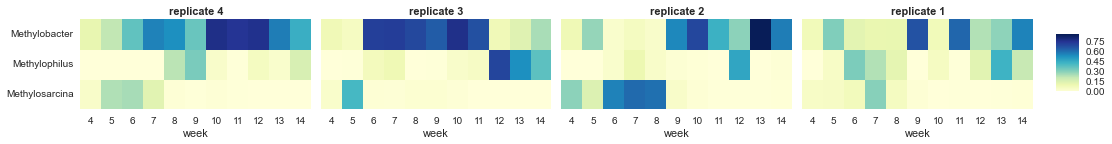

In [31]:
from abundance_plot_utils import plot_heatmap

# demo:
plot_heatmap(data=data_reduced_genus, high=0.6, low = 0.5, 
             oxy='High', rep='all', 
             plot_dir="./plots/facet_replicate")

keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Acidovorax']
filename: Low_oxygen--0.01_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Acidovorax']
filename: Low_oxygen--0.05_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other']
filename: Low_oxygen--0.1_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter']
filename: Low_oxygen--0.5_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.01_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.05_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.1_to_0.6_abundance
keep only High oxygen 

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/backends/backend_pdf.py:2036: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


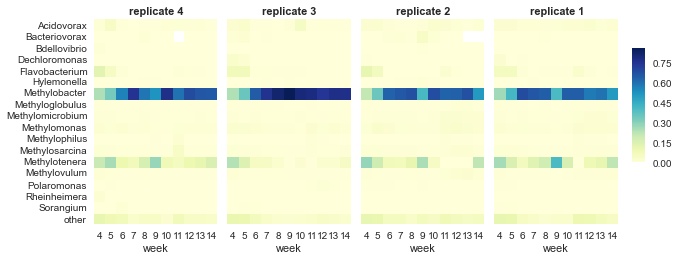

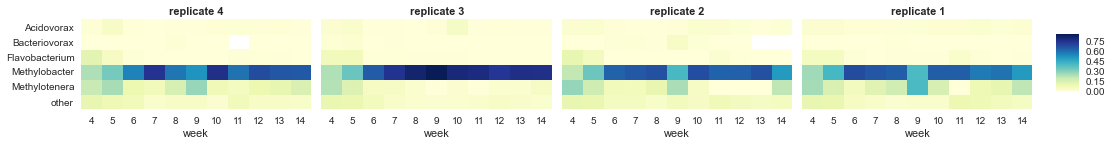

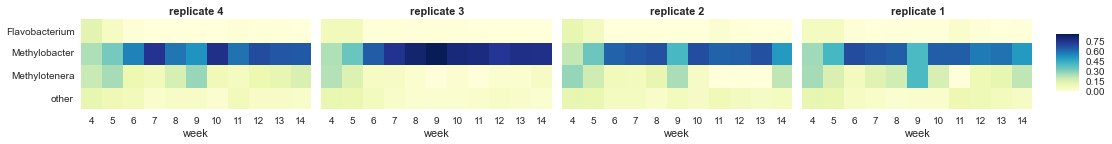

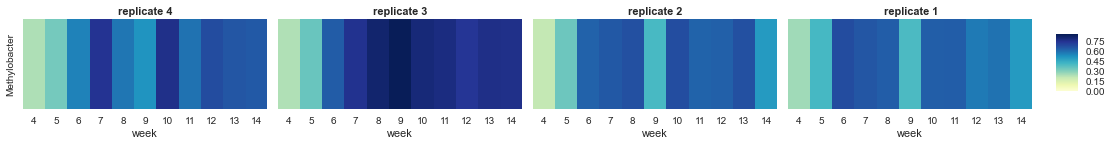

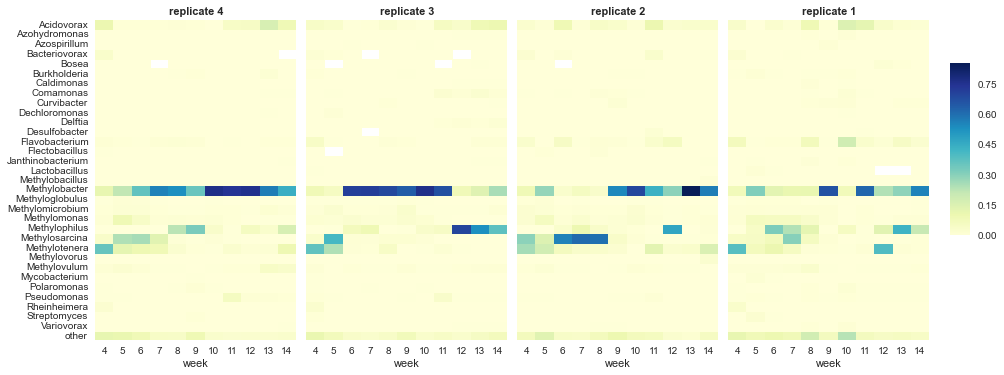

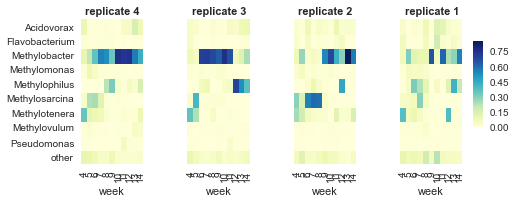

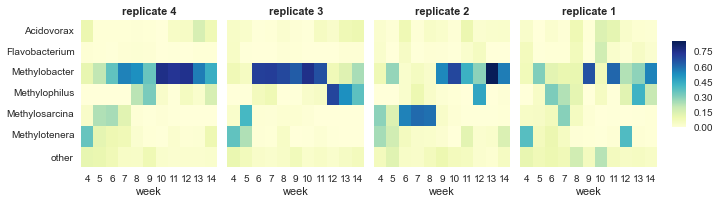

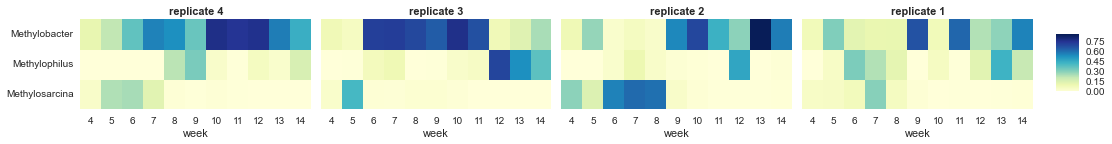

In [32]:
# Loop through the ranges we want. 
oxy_conditions = ['Low', 'High']
max_abundance = 0.6
range_pairs = [(0.01, max_abundance), 
               (0.05, max_abundance), 
               (0.1, max_abundance), 
               (0.5, max_abundance)]
for o in oxy_conditions:
    for r in range_pairs:
        #print "oxygen:", o
        #print "range:", r
        #print "range (low):", r[0]
        plot_heatmap(data=data_reduced_genus, 
                     low =r[0], high=r[1], oxy=o, rep='all',
                    plot_dir ='./plots/facet_replicate')

keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Acidovorax']
filename: Low_oxygen--0.01_to_1_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Acidovorax']
filename: Low_oxygen--0.05_to_1_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other']
filename: Low_oxygen--0.1_to_1_abundance
keep only Low oxygen samples
['Methylobacter']
filename: Low_oxygen--0.5_to_1_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.01_to_1_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.05_to_1_abundance
keep only High oxygen samples
['Methylobacter' 'Methylotenera' 'Methylophilus' 'Methylosarcina'
 'Acidovorax']
filename: High_oxygen--0.1_to_1_abundance
keep only High oxygen samples
['Meth

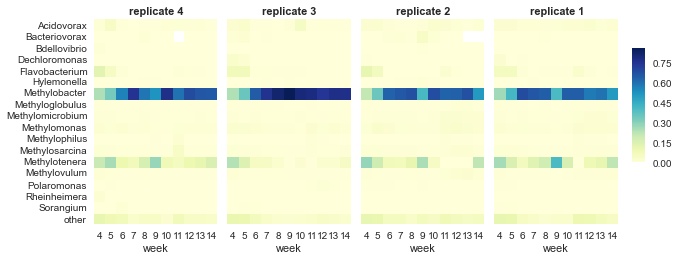

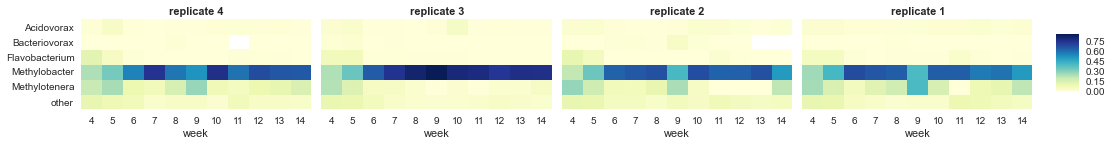

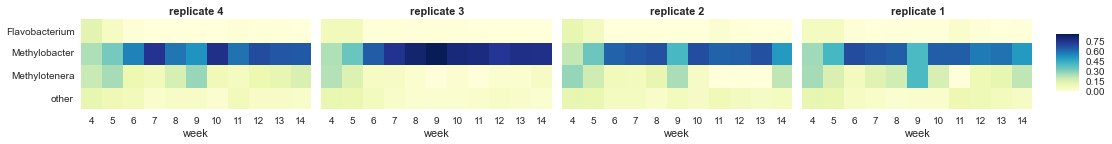

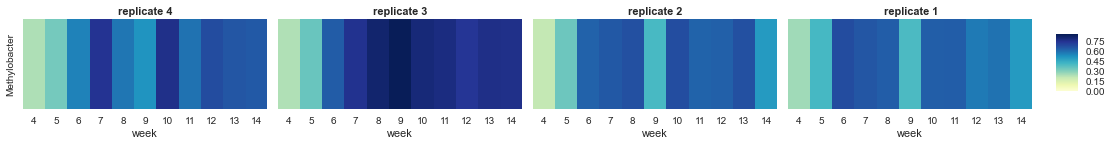

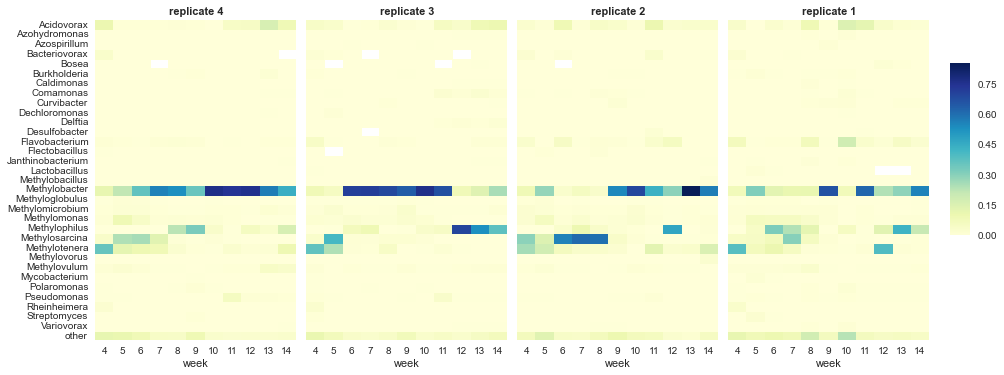

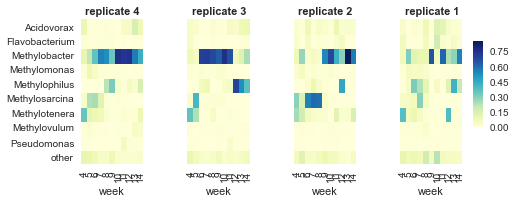

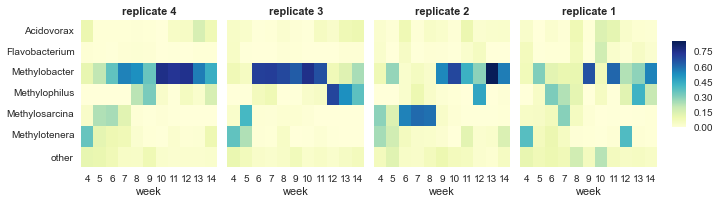

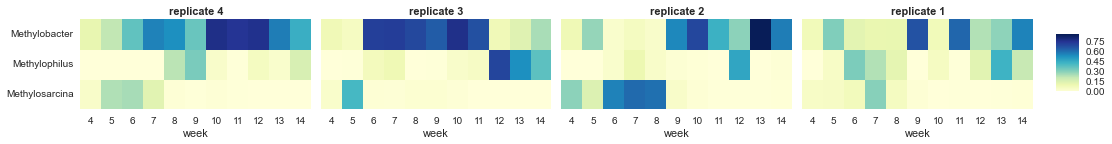

In [33]:
# Loop through the ranges we want. 
oxy_conditions = ['Low', 'High']
max_abundance = 1
range_pairs = [(0.01, max_abundance), 
               (0.05, max_abundance), 
               (0.1, max_abundance), 
               (0.5, max_abundance)]
for o in oxy_conditions:
    for r in range_pairs:
        #print "oxygen:", o
        #print "range:", r
        #print "range (low):", r[0]
        plot_heatmap(data=data_reduced_genus, 
                     low =r[0], high=r[1], oxy=o, rep='all',
                    plot_dir ='./plots/facet_replicate')